# Neural Network using Conv1d_NN (June 11, 2024)

## I. Setup

In [35]:
# Torch
import torch 
import torch.nn as nn

# MNIST1D
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

# Custom Modules
from NNT import NNT
from Conv1d_NN import Conv1d_NN

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cpu' # get summary of model

## II. Example Neural Net

In [4]:
# Example Neural Network with Conv1d
model = nn.Sequential(
    nn.Conv1d(1, 64, kernel_size=3, stride=1), 
    nn.MaxPool1d(kernel_size=2, stride=2),
    nn.Conv1d(64, 128, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2, stride=2),
    nn.Flatten(), 
    nn.Linear(128*8, 200), 
    nn.ReLU(), 
    nn.Linear(200, 10) 
).to(device)

# Get summary 
from torchsummary import summary
summary(model, (1, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 38]             256
         MaxPool1d-2               [-1, 64, 19]               0
            Conv1d-3              [-1, 128, 17]          24,704
              ReLU-4              [-1, 128, 17]               0
         MaxPool1d-5               [-1, 128, 8]               0
           Flatten-6                 [-1, 1024]               0
            Linear-7                  [-1, 200]         205,000
              ReLU-8                  [-1, 200]               0
            Linear-9                   [-1, 10]           2,010
Total params: 231,970
Trainable params: 231,970
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.88
Estimated Total Size (MB): 0.96
-------------------------------------------

## III. Conv1d_NN Neural Net

In [32]:
from NNT import NNT
# Modified Neural Network with Conv1d
model = nn.Sequential(
    Conv1d_NN(in_channels=1, out_channels =32,kernel_size=40, K = 3),  # Change the number of input channels to 1
    nn.ReLU(), 
    nn.MaxPool1d(kernel_size=2, stride=2),
    Conv1d_NN(in_channels=32, out_channels=64, kernel_size=27, K = 3),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2, stride=2),
    nn.Flatten(), 
    nn.Linear(128, 64),  # Change the number of input features to match the output of the last convolutional layer
    nn.ReLU(), 
    nn.Linear(64, 10) 
).to(device)

# Get summary 
from torchsummary import summary
summary(model, (1, 40))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 27]           1,312
         Conv1d_NN-2               [-1, 32, 27]               0
              ReLU-3               [-1, 32, 27]               0
         MaxPool1d-4               [-1, 32, 13]               0
            Conv1d-5                [-1, 64, 5]          55,360
         Conv1d_NN-6                [-1, 64, 5]               0
              ReLU-7                [-1, 64, 5]               0
         MaxPool1d-8                [-1, 64, 2]               0
           Flatten-9                  [-1, 128]               0
           Linear-10                   [-1, 64]           8,256
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 10]             650
Total params: 65,578
Trainable params: 65,578
Non-trainable params: 0
---------------------------------

## IV. Load Data from MNIST1D

In [ ]:
''' Visualization of data '''

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42}
    return arg_dict if as_dict else ObjectView(arg_dict)

# transformations of the templates which will make them harder to fit
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

# Plotting
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def plot_signals(xs, t, labels=None, args=None, ratio=2.6, do_transform=False, dark_mode=False, zoom=1):
    rows, cols = 1, 10
    fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
    for r in range(rows):
        for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            ax = plt.subplot(rows,cols,ix+1)

            # plot the data
            if do_transform:
                assert args is not None, "Need an args object in order to do transforms"
                x, t = transform(x, t, args)  # optionally, transform the signal in some manner
            if dark_mode:
                plt.plot(x, t, 'wo', linewidth=6)
                ax.set_facecolor('k')
            else:
                plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                plt.title("label=" + str(labels[ix]), fontsize=22)

            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout() ; plt.show()
    return fig

def apply_ablations(arg_dict, n=7):
    ablations = [('shear_scale', 0),
                ('iid_noise_scale', 0),
                ('corr_noise_scale', 0),
                 ('max_translation', 1),
                 ('scale_coeff', 0),
                 ('padding', [arg_dict['padding'][-1], arg_dict['padding'][-1]]),
                 ('padding', [0, 0]),]
    num_ablations = min(n, len(ablations))
    for i in range(num_ablations):
        k, v = ablations[i]
        arg_dict[k] = v
    return arg_dict

templates = get_templates()
for i, n in enumerate(reversed(range(8))):
    np.random.seed(0)
    arg_dict = get_dataset_args(as_dict=True)
    arg_dict = apply_ablations(arg_dict, n=n)
    args = ObjectView(arg_dict)
    do_transform = args.padding[0] != 0
    fig = plot_signals(templates['x'], templates['t'], labels=None if do_transform else templates['y'],
                 args=args, ratio=2.2 if do_transform else 0.8,
                 do_transform=do_transform)
#     fig.savefig(PROJECT_DIR + 'static/transform_{}.png'.format(i))

In [25]:
from mnist1d.data import make_dataset, get_dataset_args


# Customize dataset 
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42}
    return arg_dict if as_dict else ObjectView(arg_dict)


# Creating Dataset 
defaults = get_dataset_args()

data = make_dataset(defaults) 
x, y, t = torch.tensor(data['x'], dtype=torch.long).unsqueeze(1), torch.tensor(data['y'], dtype=torch.long), torch.tensor(data['t'], dtype=torch.long)
x_test, y_test = torch.tensor(data['x_test'], dtype=torch.long).unsqueeze(1), torch.tensor(data['y_test'], dtype=torch.long)


In [27]:
print(x.shape, y.shape, t.shape)
print(x_test.shape, y_test.shape)
print(x.dtype, y.dtype, t.dtype)

torch.Size([4000, 1, 40]) torch.Size([4000]) torch.Size([40])
torch.Size([1000, 1, 40]) torch.Size([1000])
torch.int64 torch.int64 torch.int64


In [28]:
# Configure data

from torch.utils.data import Dataset, DataLoader 

class MNIST1DDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = MNIST1DDataset(x, y) 
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = MNIST1DDataset(x_test, y_test)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

## V. Train model 


In [29]:
# Configure Training
from torch.optim import Adam 
loss_fn = nn.CrossEntropyLoss()
opt = Adam(model.parameters(), lr=1e-3)

def train_batch(x, y, model, opt, loss_fn): 
    model.train() 
    
    opt.zero_grad()
    batch_loss = loss_fn(model(x), y)
    batch_loss.backward()
    opt.step()
    
    return batch_loss.detach().cpu().numpy()

@torch.no_grad()
def accuracy(x, y, model): 
    model.eval() 
    
    prediction = model(x)
    argmaxes = prediction.argmax(dim=1)
    s = torch.sum(((argmaxes == y).float())/len(y))
    return s.cpu().numpy()



In [31]:
# Training Network 
import numpy as np

losses, accuracies = [], [] 
n_epochs = 5

for epoch in range(n_epochs):
    print(f"Running epoch {epoch+1} of {n_epochs}")
    
    epoch_losses, epoch_accuracies = [], []
    
    for batch in train_dl: 
        x, y = batch 
        batch_loss = train_batch(x, y, model, opt, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.mean(epoch_losses) 
    
    for batch in train_dl: 
        x, y = batch 
        batch_acc = accuracy(x, y, model)
        epoch_accuracies.append(batch_acc)
    epoch_accuracy = np.mean(epoch_accuracies)
    
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)
        

Running epoch 1 of 5
Running epoch 2 of 5
Running epoch 3 of 5
Running epoch 4 of 5
Running epoch 5 of 5


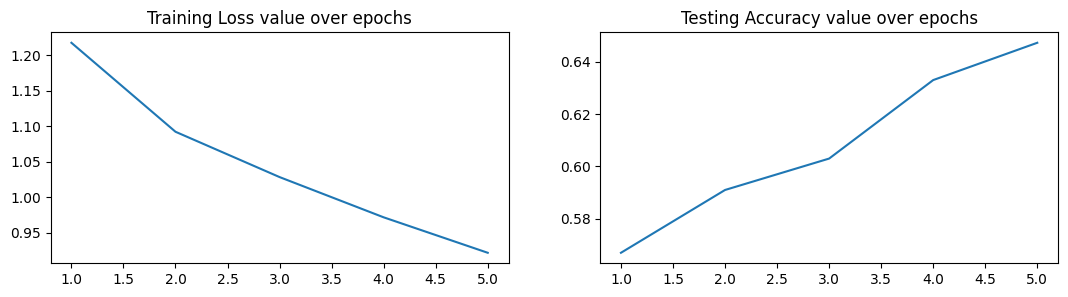

In [40]:
# Visualize how it did during training 
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 3))
plt.subplot(121)
plt.title("Training Loss value over epochs")
plt.plot(np.arange(n_epochs) + 1, losses)
plt.subplot(122)
plt.title("Testing Accuracy value over epochs") 
plt.plot(np.arange(n_epochs) + 1, accuracies)

In [39]:
# Testing the learned classifier 
epoch_accuracies = [] 
for ix, batch in enumerate(iter(test_dl)): 
    x, y = batch 
    batch_acc = accuracy(x, y, model)
    epoch_accuracies.append(batch_acc)

print(f"Test accuracy: {np.mean(epoch_accuracies):.6f}")
    

Test accuracy: 0.089844
